<a href="https://colab.research.google.com/github/Vidzhel/data-analysis/blob/main/NLP_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ресурси
- https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/

In [58]:
!pip list -v | grep torch

torch                         1.13.1+cu116           /usr/local/lib/python3.8/dist-packages pip
torchaudio                    0.13.1+cu116           /usr/local/lib/python3.8/dist-packages pip
torchsummary                  1.5.1                  /usr/local/lib/python3.8/dist-packages pip
torchtext                     0.14.1                 /usr/local/lib/python3.8/dist-packages pip
torchvision                   0.14.1+cu116           /usr/local/lib/python3.8/dist-packages pip


In [2]:
import requests
from bs4 import BeautifulSoup
import re
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk

# Завантажуємо файл Енеїди Котляревського
url = 'https://www.ukrlib.com.ua/books/getfile.php?tid=1052&type=6'
response = requests.get(url)

Парсинг html файлу та виокремлення тексту, видалення тегів, коментарів, цифр та інших символів що не відносяться до букв українського алфавіту. Токенізація тексту.

In [41]:
soup = BeautifulSoup(response.content, 'html.parser')
poem_text = soup.body.get_text()

# Remove all tags from the text
poem_text = re.sub(r'<.*?>', '', poem_text)

# Remove all comments that start after 'КОМЕНТАР ДО'
poem_text = poem_text.split('КОМЕНТАР ДО', 1)[0]

# Tokenize the text
poem_text=re.sub(r"""[0-9]""", r" ", poem_text)
poem_text=re.sub(r"""[^А-ЩЬЮЯҐЄІЇа-щьюяґєії'\n]""", ' ', poem_text)
rows=poem_text.lower().split("\n")
rows=[row for row in rows if row]
rows_words = [[word for word in row.split(" ") if word] for row in rows]
words = [word for words in rows_words for word in words if word]

Частотний аналіз н-грам тексту (цікаво які слова найчастіше зустрічаються)

In [20]:
!pip install pymorphy2
!pip install pymorphy2-dicts-uk

import pandas as pd
import pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 61.9 MB/s eta 0:00:00


Кількість символів:  690
Кількість токенів:  690
Кількість унікальних токенів:  506
Найбільш уживані токени:  [(('еней',), 14), (('я',), 11), (('бути',), 10), (('йога',), 8), (('юнона',), 7), (('еол',), 6), (('ти',), 6), (('вона',), 5), (('венера',), 5), (('взяти',), 5), (('же',), 5), (('пливти',), 5), (('тогда',), 5), (('город',), 5), (('троя',), 4), (('дати',), 4), (('уже',), 4), (('сказати',), 4), (('чи',), 4), (('зараза',), 4)]


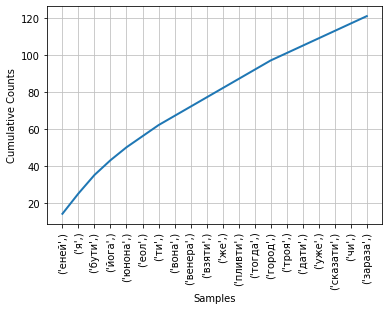

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [35]:
stop_words = "з, у, як, що, тут, щоб, так, то, по, та, а, або, аби, аж, але, аналогічно, б, багато, без, більш, більше, бо, буває, було, бути, в, вам, вас, весь, вже, від, він, вона, вони, все, всі, всіх, вся, втім, г, геть, говорив, говорить, д, да, давно, далеко, дарма, де, де-не-де, дехто, дещо, дійсно, для, до, довго, доводиться, досить, доцільно, дуже, е, є, ж, життя, за, звідки, звідси, звісно, здається, зі, знову, зовсім, і, із, іноді, ї, її, їм, їх, їхній, їхня, їхнє, й, к, каже, кілька, коли, колись, кому, конкретно, краще, крім, куди, ледве, ледь, лише, м, має, майже, мало, мене, мені, менш, ми, мимоволі, минулого, минулому, міг, між, мій, мільйонів, мною, могти, моє, мої, може, можливо, море, моя, на, навіть, навіщо, навіщось, над, найбільш, нам, нами, нарешті, нас, наш, наша, наше, наші, не, нею, ні, ніби, ніж, ніякий, нічого, ну, об, обоє, от, отже, оце, оцей, оцю, особливо, особливості, особливою, ось, перед, перш, під, підсумовуючи, після, поки, пора, порівняно, поряд, порядку, початку, по-друге, по-перше, правда, право, прекрасно, при, причому, про, просто, проте, після, ради, раніше, раз, разом, років, року, році, розмірковує, рік, с, сам, сама, саме, самим, самими, самі, самого, самому, себе, собі"
stop_words = set(stop_words.split(", "))
morph = pymorphy2.MorphAnalyzer(lang="uk")

series = pd.Series(words)
series = [s for s in series if s not in stop_words]
series = [morph.parse(s)[0].normal_form for s in series]
print ('Кількість символів: ',len(series))
series=nltk.ngrams(series,1)
series=nltk.FreqDist(series)
print('Кількість токенів: ', series.N())
print('Кількість унікальних токенів: ', series.B())
print('Найбільш уживані токени: ', series.most_common(20))
series.plot(20, cumulative = True)

Будуємо декількашарову модель нейронної мережі на основі бібліотеки PyTorch, головна задача якої отримати на вхід послідовність слів (токенів) та обрати одне наступне з відомих мережі. Основними шарами моделі є шари LSTM (Long short-term memor) - модифікована версія RNN, що на відміну від шарів інших видів (звичайні чи convolutional) генерують результат опираючись також на попередньо отримані дані (попередні слова в речені, попередні кадри у відео). Шари Embedding та Linear трансформують вхідні та вихідні дані відповідно.

In [50]:
# Define the PyTorch dataset
class LanguageModelDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        words,
        sequence_length,
    ):
        self.sequence_length = sequence_length
        self.words = words
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )


# Define the LSTM-based language model
class LanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super(LanguageModel, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, vocab_size)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))


# Set the hyperparameters
sequence_length = 20
learning_rate = 0.1
batch_size = 2
n_epochs = 10

words = words[:2500]
# Create the PyTorch dataset and rows_words loader
dataset = LanguageModelDataset(words, sequence_length)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create the PyTorch model and optimizer
model = LanguageModel(len(dataset.uniq_words))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Процес навчання відбувається шляхом виокремлення послідовностей слів з нашого набору тексту по дві за раз, перша буде даватися як вхідний параметр, другий щоб порівняти з обраними нейронною мережею. Очікувані та отрмані результати будуть порівнюватися з використанням функції, в цьому випадку CrossEntropyLoss, значення якої оптимізатор буде намагатися мінімізувати шляхом визначення градієнту, оберненного поширення (backward propagation) похідної та коректування вагів. Параметр learning_rate використовується як коефіцієнт коректування вагів (по суті крок кроку в пошуках мінімума функції). Чим він більший, тим швидше буде відбуватися зміна, однак є небезпека пропустити мінімум, чи менше тим довше та точніше тренування, але є ризик перенавчання моделі. Навчання складається з певної кількості епох - повторних проходів по начальним даним.

Для роботи моделі з словами, вони кодуються (будується словник), простіше кажучи, з усього набору слів відкидаються повтори, індекси слів і будуть їх кодом.

Для навчання використовуються лише 2500 перших слів з більше 30 000 доступних через довгий час навчання. Як додаткове завдання, в кого є доступ до cuda, можна трішки модифікувати та запустити алгоритм на відеокарті. 

In [51]:
# Train the model
model.train()

for epoch in range(n_epochs):
    state_h, state_c = model.init_state(sequence_length)
    loss = None

    for batch, (x, y) in enumerate(data_loader):
        optimizer.zero_grad()

        y_pred, (state_h, state_c) = model(x, (state_h, state_c))
        loss = criterion(y_pred.transpose(1, 2), y)

        state_h = state_h.detach()
        state_c = state_c.detach()

        loss.backward()
        optimizer.step()

    print({ 'epoch': epoch, 'loss': loss.item() })

{'epoch': 0, 'loss': 6.4794793128967285}
{'epoch': 1, 'loss': 8.722543716430664}
{'epoch': 2, 'loss': 8.499884605407715}
{'epoch': 3, 'loss': 7.188836574554443}
{'epoch': 4, 'loss': 7.6822190284729}
{'epoch': 5, 'loss': 6.976107597351074}
{'epoch': 6, 'loss': 8.26357650756836}
{'epoch': 7, 'loss': 8.551206588745117}
{'epoch': 8, 'loss': 7.585450172424316}
{'epoch': 9, 'loss': 8.450400352478027}


Для перевірки, використовуємо речення з уже відомих слів. Результат буває цікавим, хоча рідко має сенс

In [60]:
import numpy as np

def predict(dataset, model, text, next_words=10):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words

print(" ".join(predict(dataset, model, text='но гірш за те їй не любився')))

но гірш за те їй не любився не плавати ти багацько причепурилась тута берега звелів помилуй еней
